数据集大小： 1000


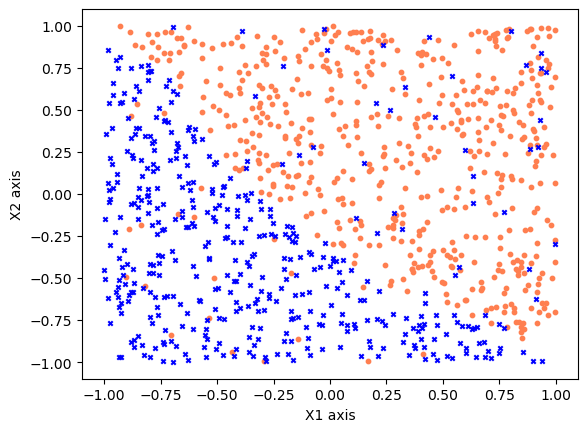

In [25]:
from re import X

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

lines=np.loadtxt('lr_dataset.csv',delimiter=',',dtype=float) # 导入数据，存入变量lines中
x_total=lines[:,0:2] # 取出第1和第2列所有的数据作为特征集
y_total=lines[:,2] # 取出第3列作为标签集
print('数据集大小：',len(x_total))

pos_index=np.where(y_total==1) # 以元组的形式返回标签集中所有标签值为1的下标
neg_index=np.where(y_total==0) # 以元组的形式返回标签集中所有标签值为0的下标
plt.scatter(x_total[pos_index,0],x_total[pos_index,1],marker='o',color='coral',s=10) # 标签为1的点
plt.scatter(x_total[neg_index,0],x_total[neg_index,1],marker='x',color='blue',s=10) # 标签为0的点
plt.xlabel('X1 axis')
plt.ylabel('X2 axis')
plt.show()

np.random.seed(0) # 设置随机数种子为0
ratio=0.7 # 训练集占比0.7
split=int(ratio*len(x_total)) # 计算训练集数量，int强转为整数保证分离正常
idx=np.random.permutation(len(x_total)) # 将数据集中所有的数据打乱，下标赋值给idx
x_total=x_total[idx] # 将特征集根据idx进行重排
y_total=y_total[idx] # 将标签集根据idx进行重排
x_train,y_train=x_total[:split],y_total[:split] # 将打乱后的前split个样本作为训练集的特征数据和标签数据
x_test,y_test=x_total[split:],y_total[split:] # 将打乱后的前split个样本作为测试集的特征数据和标签数据

In [26]:
def acc(y_true,y_pred):
    '''
    y_true == y_pred会生成一个布尔数组，其中每个元素表示对应位置的真实标签和预测标签是否相等。np.mean函数计算这个布尔数组中True值的比例，即准确率
    :param y_true: 
    :param y_pred: 
    :return: 
    '''
    return np.mean(y_true==y_pred)

def auc(y_true,y_pred):
    idx=np.argsort(y_pred)[::-1] # 从大到小的顺序排列
    y_true=y_true[idx] # 从大到小的顺序排列
    y_pred=y_pred[idx] # 从大到小的顺序排列
    tp=np.cumsum(y_true) # np.cumsum函数计算累积和,tp储存y_true == 1的数量
    fp=np.cumsum(1-y_true) # fp储存y_true == 0的数量
    tpr=tp/tp[-1] # 计算TPR
    fpr=fp/fp[-1] # 计算FPR
    s=0.0
    tpr=np.concatenate([[0],tpr]) # 在开头加1个数值为0的元素，即加入【0,0】坐标
    fpr=np.concatenate([[0],fpr])
    for i in range(1,len(fpr)):
        s+=(fpr[i]-fpr[i-1])*tpr[i] # 近似计算 ROC 曲线下的面积
    return s

In [27]:
def logistic(z):
    return 1/(1+np.exp(-z)) # 逻辑斯蒂函数（Sigmoid函数）

def GD(num_steps,learning_rate,l2_coef):
    theta=np.random.normal(size=(X.shape[1],)) # 初始化模型的参数，等于特征的数量
    train_losses=[]
    test_losses=[]
    train_acc=[]
    test_acc=[]
    train_auc=[]
    test_auc=[]
    for i in range(num_steps):
        pred=logistic(X@theta) # 根据逻辑斯蒂函数计算训练集的概率
        grad=-X.T@(y_train-pred)+l2_coef*theta # 计算梯度
        theta-=learning_rate*grad # 根据学习率更新参数theta
        train_loss=-y_train.T@np.log(pred)-(1-y_train).T@np.log(1-pred)+l2_coef*np.linalg.norm(theta)**2/2 # 加入L2正则项
        train_losses.append(train_loss/len(X))
        test_pred=logistic(X_test@theta) # 计算测试集的预测概率
        test_loss=-y_test.T@np.log(test_pred)-(1-y_test).T@np.log(1-test_pred) # 计算测试集的损失
        test_losses.append(test_loss/len(X_test)) # 测试集的平均损失
        train_acc.append(acc(y_train,pred>=0.5)) # 分别将训练集和测试集的预测概率转换为二进制标签，acc函数计算训练集和测试集的准确率
        test_acc.append(acc(y_test,test_pred>=0.5))
        train_auc.append(auc(y_train,pred)) # auc函数计算训练集和测试集的AUC值
        test_auc.append(auc(y_test,test_pred))
    return theta, train_losses, test_losses, train_acc, test_acc, train_auc, test_auc

预测准确率： 0.8766666666666667
回归系数： [3.13501827 2.90998799 0.55095127]


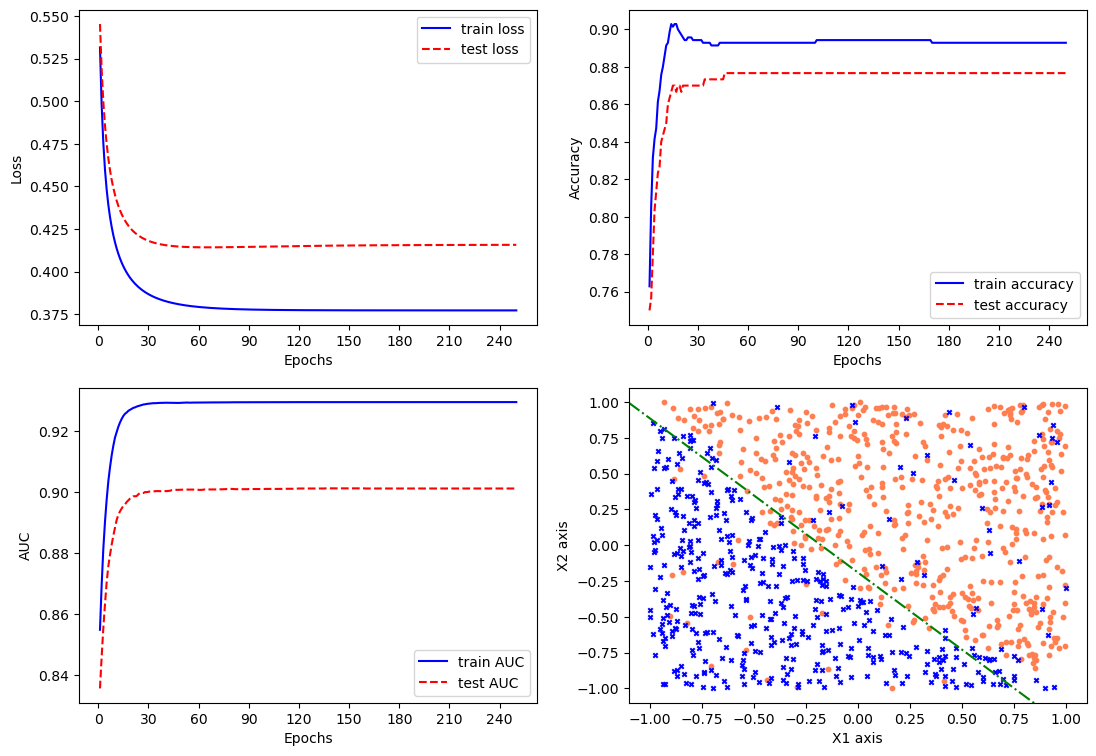

In [28]:

num_steps=250 # 迭代次数
learning_rate=0.002 # 学习率，即步长
l2_coef=1.0 # 正则化系数
np.random.seed(0)

X=np.concatenate([x_train,np.ones((x_train.shape[0],1))],axis=1) # 在最后一列加入偏置项
X_test=np.concatenate([x_test,np.ones((x_test.shape[0],1))],axis=1) # 在最后一列加入偏置项
theta,train_losses,test_losses,train_acc,test_acc,train_auc,test_auc=GD(num_steps,learning_rate,l2_coef) # 调用GD函数
y_pred=np.where(logistic(X_test@theta)>=0.5,1,0) # 对测试集进行预测，大于等于0.5的记为1，否则记为0
final_acc=acc(y_test,y_pred) # 调用acc函数，计算测试集上的预测准确率
print('预测准确率：',final_acc)
print('回归系数：',theta)

plt.figure(figsize=(13,9)) # 图的大小
xticks=np.arange(num_steps)+1 # x轴刻度

plt.subplot(221) # 2行2列的第一个位置
plt.plot(xticks,train_losses,color='blue',label='train loss')
plt.plot(xticks,test_losses,color='red',ls='--',label='test loss')
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(222)
plt.plot(xticks, train_acc, color='blue', label='train accuracy')
plt.plot(xticks, test_acc, color='red', ls='--', label='test accuracy')
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(223)
plt.plot(xticks, train_auc, color='blue', label='train AUC')
plt.plot(xticks, test_auc, color='red', ls='--', label='test AUC')
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()

plt.subplot(224)
plot_x = np.linspace(-1.1, 1.1, 100)
plot_y = -(theta[0] * plot_x + theta[2]) / theta[1]
pos_index = np.where(y_total == 1)
neg_index = np.where(y_total == 0)
plt.scatter(x_total[pos_index, 0], x_total[pos_index, 1], marker='o', color='coral', s=10)
plt.scatter(x_total[neg_index, 0], x_total[neg_index, 1], marker='x', color='blue', s=10)
plt.plot(plot_x, plot_y, ls='-.', color='green')
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.xlabel('X1 axis')
plt.ylabel('X2 axis')
plt.savefig('output_16_1.png')
plt.savefig('output_16_1.pdf')
plt.show()

In [29]:
from sklearn.linear_model import LogisticRegression
lr_clf=LogisticRegression(solver='liblinear')
lr_clf.fit(x_train,y_train)
print('回归系数：',lr_clf.coef_[0],lr_clf.intercept_)
y_pred=lr_clf.predict(x_test)
print('准确率为：',np.mean(y_pred==y_test))


回归系数： [3.14129907 2.91620111] [0.5518978]
准确率为： 0.8766666666666667
